In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

In [2]:
df = pd.read_csv('/content/pca_transformed_data_25.csv')

In [3]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [4]:
print(f"Original dataframe size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Original dataframe size: 50000
Training set size: 35000
Validation set size: 7500
Testing set size: 7500


In [5]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l2'],              # L1 requires solver='liblinear' or 'saga'
    'solver': ['lbfgs']             # Suitable for small-to-medium datasets
}

In [6]:
# === Define model
logistic_regression = LogisticRegression(max_iter=1000)

# === Grid search with 5-fold cross-validation
grid_search_lr = GridSearchCV(
    estimator=logistic_regression,
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [7]:
# === Train model using PCA-reduced features
X_train_pca = df_train.drop('Test Results', axis=1)
y_train = df_train['Test Results']

In [8]:
grid_search_lr.fit(X_train_pca, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy', verbose=2)

In [9]:
# === Best model
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation accuracy for Logistic Regression:", grid_search_lr.best_score_)

Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy for Logistic Regression: 0.7694571428571428


In [10]:
# === Evaluation on validation and test sets
X_val_pca = df_val.drop('Test Results', axis=1)
y_val = df_val['Test Results']
y_val_pred = grid_search_lr.predict(X_val_pca)

In [11]:
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

X_test_pca = df_test.drop('Test Results', axis=1)
y_test = df_test['Test Results']
y_test_pred = grid_search_lr.predict(X_test_pca)

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      2464
           1       0.73      0.71      0.72      2509
           2       0.78      0.81      0.80      2527

    accuracy                           0.76      7500
   macro avg       0.76      0.76      0.76      7500
weighted avg       0.76      0.76      0.76      7500


Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2547
           1       0.73      0.72      0.72      2440
           2       0.80      0.82      0.81      2513

    accuracy                           0.77      7500
   macro avg       0.77      0.77      0.77      7500
weighted avg       0.77      0.77      0.77      7500



In [12]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Get the best model from GridSearchCV
best_lr_model = grid_search_lr.best_estimator_

# Make predictions on the test set
y_pred_test_lr = best_lr_model.predict(df_test.drop('Test Results', axis=1))
y_true_test_lr = df_test['Test Results']

# Get the classification report as a dictionary
report = classification_report(y_true_test_lr, y_pred_test_lr, output_dict=True)

# Extract the desired metrics.
# We'll focus on the weighted averages.
precision = report['weighted avg']['precision']
sensitivity = report['weighted avg']['recall'] # Recall is sensitivity
f1_score = report['weighted avg']['f1-score']
accuracy = accuracy_score(y_true_test_lr, y_pred_test_lr)

# Create a dictionary to store the metrics
metrics_data = {
    'Metric': ['Precision', 'Sensitivity', 'F1 Score', 'Accuracy'],
    'Value': [precision, sensitivity, f1_score, accuracy]
}

# Create a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
print("Performance Metrics for Logistic Regression on Test Set:")
display(metrics_df)

Performance Metrics for Logistic Regression on Test Set:


,Metric,Value
0,Precision,0.772517
1,Sensitivity,0.772800
2,F1 Score,0.772613
3,Accuracy,0.772800


In [13]:
# Print Accuracy
print("Accuracy:", accuracy)

Accuracy: 0.7728


In [14]:
model_filename = 'best_logistic_regression_model.pkl'
joblib.dump(best_lr_model, model_filename)

['best_logistic_regression_model.pkl']

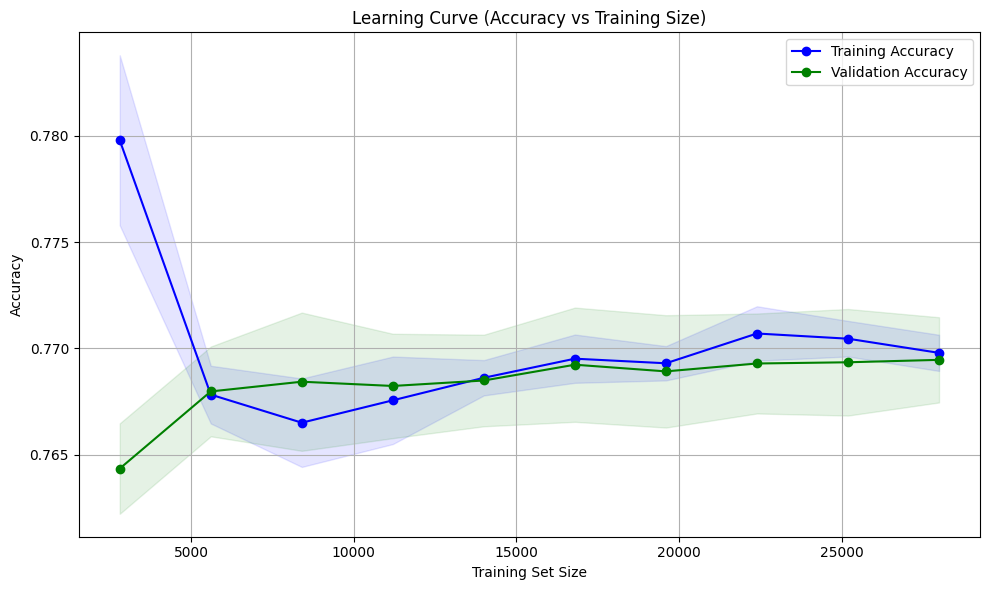

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_lr_model,
    df_train.drop('Test Results', axis=1),
    df_train['Test Results'],
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    random_state=42
)

# Mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='green')

plt.title('Learning Curve (Accuracy vs Training Size)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


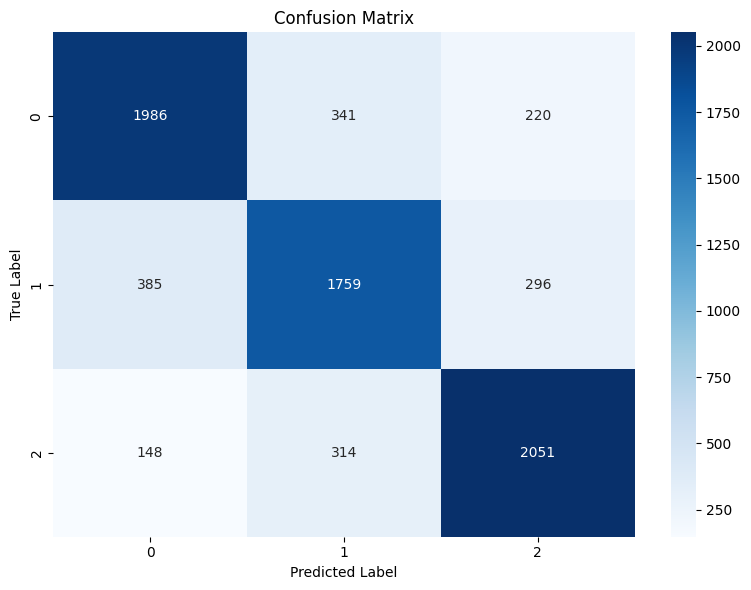

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_test = df_test['Test Results']
X_test = df_test.drop('Test Results', axis=1)
y_pred = best_lr_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = best_lr_model.classes_  # Get class labels from the model

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
